<a href="https://colab.research.google.com/github/tesfayeamare/Binarized-Neural-Networks-on-cifar10-and-Mnist-Dataset/blob/main/BNN_on_Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/google/qkeras 

In [ ]:
import tensorflow as tf
# Check tfkeras and tf version
print('Tf Keras: {}'.format(tf.keras.__version__))
print('TensorFlow: {}'.format(tf.__version__))

Tf Keras: 2.7.0
TensorFlow: 2.7.0


In [ ]:
!pip uninstall tensorflow==2.8.0
!pip install tensorflow==2.7.0

In [ ]:
from qkeras import *

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, MaxPooling2D, AveragePooling2D, BatchNormalization, Activation, Reshape, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import random

from PIL import Image

import os



In [ ]:
# convert from color image (RGB) to grayscale
# source: opencv.org
# grayscale = 0.299*red + 0.587*green + 0.114*blue
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

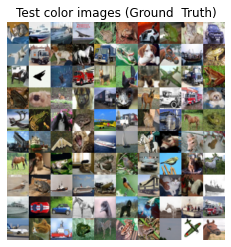

In [ ]:
# Load data from TF Keras
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# input image dimensions
# we assume data format "channels_last"
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

# create saved_images folder
imgs_dir = 'saved_images'
save_dir = os.path.join(os.getcwd(), imgs_dir)
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

# display the 1st 100 input images (color and gray)
imgs = x_test[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs)
plt.savefig('%s/test_color.png' % imgs_dir)
plt.show()





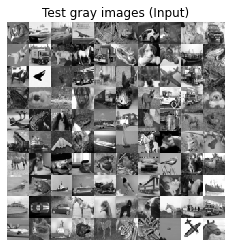

In [ ]:
# convert color train and test images to gray
x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)
# display grayscale version of test images
imgs = x_test_gray[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('%s/test_gray.png' % imgs_dir)
plt.show()

In [ ]:
# CIFAR10 class names
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

num_classes = len(class_names)

# Normalize pixel values to be between 0 and 1
x_train = x_train.astype(np.float32)/255
x_test = x_test.astype(np.float32)/255

x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], x_train_gray.shape[1], x_train_gray.shape[2], 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], x_test_gray.shape[1], x_test_gray.shape[2], 1)

# normalize input train and test grayscale images
x_train_gray = x_train_gray.astype(np.float32)/255
x_test_gray = x_test_gray.astype(np.float32)/255

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Print color arrays shape
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

# Print gray arrays shape
print('x_train_gray_shape:', x_train_gray.shape)
print('y_train_gray shape:', y_train.shape)
print('x_test_gray_shape:', x_test_gray.shape)
print('y_test_gray shape:', y_test.shape)

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 10)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 10)
x_train_gray_shape: (50000, 32, 32, 1)
y_train_gray shape: (50000, 10)
x_test_gray_shape: (10000, 32, 32, 1)
y_test_gray shape: (10000, 10)


In [ ]:
batch_size = 64

img_rows, img_cols = x_train.shape[1], x_train.shape[2] # input image dimensions
input_shape = (x_train.shape[1], x_train.shape[2], 1)
print(input_shape)


input_shape_gray = (x_train_gray.shape[1], x_train_gray.shape[2], x_train_gray.shape[3])
print(input_shape_gray)

(32, 32, 1)
(32, 32, 1)


In [ ]:
x_train = (x_train*255)-128
x_test = (x_test*255)-128

x_train_gray = (x_train_gray*255)-128
x_test_gray = (x_test_gray*255)-128

In [ ]:
def get_model():
    #input_shape=[32,32,3] # default size for colored cifar10
    num_classes=10 # default class number for cifar10

#    inputs = Input(shape=input_shape)
    inputs = Input(input_shape_gray)
    x = QActivation("quantized_bits(8, 7, alpha=1)", name="act_0")(inputs)   
    x = QConv2D(128,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4),
                  kernel_quantizer="quantized_bits(8, 7, alpha=1)", 
                  use_bias = False,
                  name="conv2d_A")(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.999, scale=False)(x)
    x = QActivation("binary(alpha=1)", name="act_1")(x)
    
    x = QConv2D(128,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4),
                  kernel_quantizer="binary(alpha=1)", 
                  use_bias = False,
                  name="conv2d_B")(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.999, scale=False)(x)
    x = QActivation("binary(alpha=1)", name="act_2")(x)

    x = QConv2D(256,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4),
                  kernel_quantizer="binary(alpha=1)", 
                  use_bias = False,
                  name="conv2d_C")(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.999, scale=False)(x)
    x = QActivation("binary(alpha=1)", name="act_3")(x)

    x = QConv2D(256,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4),
                  kernel_quantizer="binary(alpha=1)", 
                  use_bias = False,
                  name="conv2d_D")(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.999, scale=False)(x)
    x = QActivation("binary(alpha=1)", name="act_4")(x)

    x = QConv2D(512,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4),
                  kernel_quantizer="binary(alpha=1)", 
                  use_bias = False,
                  name="conv2d_E")(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.999, scale=False)(x)
    x = QActivation("binary(alpha=1)", name="act_5")(x)

    x = QConv2D(512,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4),
                  kernel_quantizer="binary(alpha=1)", 
                  use_bias = False,
                  name="conv2d_F")(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.999, scale=False)(x)
    x = QActivation("binary(alpha=1)", name="act_6")(x)

    x = tf.keras.layers.Flatten()(x)

    x = QDense(1024,
        kernel_quantizer="binary(alpha=1)",
        bias_quantizer="binary(alpha=1)",
        name="dense1")(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.999, scale=False)(x)
    x = QActivation("binary(alpha=1)", name="act_7")(x)

    x = QDense(1024,
        kernel_quantizer="binary(alpha=1)",
        bias_quantizer="binary(alpha=1)",
        name="dense2")(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.999, scale=False)(x)
    x = QActivation("binary(alpha=1)", name="act_8")(x)

    x = QDense(10,
        kernel_quantizer="binary(alpha=1)",
        bias_quantizer="binary(alpha=1)",
        name="dense3")(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.999, scale=False)(x)
    x = tf.keras.layers.Activation("softmax")(x)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=x)
    return model

In [ ]:
# check model structure and the number of parameters
model = get_model()
#model.summary()

# Optimizer has been changed from RMSprop to Adam, which seens be a litte better
# Besides, learing rate has been tuned
# opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
#opt = tf.keras.optimizers.Adam(learning_rate = 0.01, beta_2 = 0.00001)
opt = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
#tf.keras.optimizers.Adam(lr=0.01, decay=0.0001),

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
model.summary()

In [ ]:
model.save("./cifar10_qkeras.h5")

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
# prepare iterator
it_train = datagen.flow(x_train_gray, y_train, batch_size=64)
 
epochs = 100

print(x_test_gray.shape)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
history = model.fit(it_train,
          batch_size=batch_size,
          epochs=epochs, 
          callbacks=[callback],
          validation_data=(x_test_gray, y_test))



In [ ]:
model.save("./cifar10_qkeras.h5")

In [ ]:
scores = model.evaluate(x_test_gray, y_test, verbose=1)

In [ ]:
# learning curves
# plot diagnostic learning curves
import sys
from matplotlib import pyplot

# plot loss
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(history.history['loss'], color='blue', label='train')
pyplot.plot(history.history['val_loss'], color='orange', label='test')
# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(history.history['accuracy'], color='blue', label='train')
pyplot.plot(history.history['val_accuracy'], color='orange', label='test')

plt. show()

# save plot to file
filename = sys.argv[0].split('/')[-1]
pyplot.savefig(filename + '_plot.png')
pyplot.close()

In [ ]:
from google.colab import files
files.download("./cifar10_qkeras.h5")

In [ ]:
import numpy as np
# import qkeras
import tensorflow as tf
# import tensorflow.keras as keras

BATCH_SIZE = 128
EPOCHS = 100
NUM_CLASSES = 10


x_test_gray = x_test_gray[:100]
x_test_gray = x_test_gray.astype(np.int8)
y_test = y_test[:100]
y_test = y_test.astype(np.float32)
y_test = y_test
y_test = y_test.astype(np.int8)
print(x_train_gray.shape)
print(y_test.shape)
np.save('x_int8_100_cifar10.npy', x_test_gray)
np.savez('int8_100_cifar10.npz', in_0=x_test_gray, out_0=y_test)

from google.colab import files
files.download("./int8_100_cifar10.npz")

In [ ]:
# Shall be at the end of the notebook
print_qstats(model)